In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import pandas

import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels
from statsmodels.tsa.stattools import adfuller #ADF TEST
from statsmodels.tsa.seasonal import seasonal_decompose #시계열 분해
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima




print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


## 주가 예측 실습

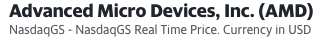

In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AMD.csv'
amd = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
amd

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-04,77.949997,78.669998,77.040001,78.610001,78.610001,59194300
2021-05-05,79.050003,79.300003,77.360001,77.830002,77.830002,42310200
2021-05-06,77.629997,78.059998,76.470001,77.889999,77.889999,38661300
2021-05-07,78.750000,79.570000,78.220001,78.809998,78.809998,36954200
2021-05-10,78.199997,78.300003,75.919998,75.989998,75.989998,45134500
...,...,...,...,...,...,...
2022-04-27,84.250000,87.900002,84.019997,84.910004,84.910004,83125100
2022-04-28,86.669998,90.580002,84.779999,89.639999,89.639999,91495400
2022-04-29,88.050003,91.790001,85.379997,85.519997,85.519997,82568500


In [3]:
amd = amd['Close'] # 주식 종가

In [4]:
#보간 : 연속성이 있는 데이터의 앞뒤값을 이용한 결측치 채우기
amd = amd.interpolate(method='time')
amd[amd.isna()]

Series([], Name: Close, dtype: float64)

In [5]:
#로그로 변환
amd_log = np.log(amd)
amd_log

Date
2021-05-04    4.364499
2021-05-05    4.354527
2021-05-06    4.355298
2021-05-07    4.367040
2021-05-10    4.330602
                ...   
2022-04-27    4.441592
2022-04-28    4.495802
2022-04-29    4.448750
2022-05-02    4.498030
2022-05-03    4.512287
Name: Close, Length: 253, dtype: float64

In [6]:
#이동평균
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [7]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

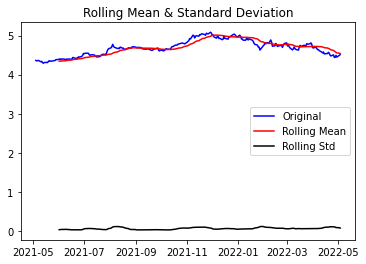

Results of Dickey-Fuller Test:
Test Statistic                  -1.644205
p-value                          0.460064
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


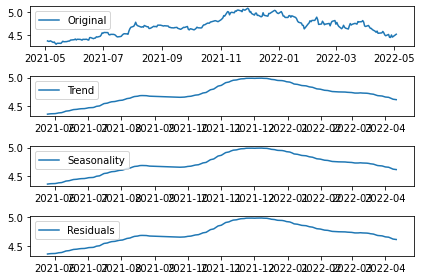

In [8]:
# 정성적 그래프 분석 주식시장의 기술적지표의 window 기준은 5,20,60 ... 
plot_rolling_statistics(amd_log, window=20)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(amd_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(amd_log, model='multiplicative', period = 30) 

trend = decomposition.trend # MA
seasonal = decomposition.seasonal #계절성 제거
residual = decomposition.resid #잔차

plt.subplot(411)
plt.plot(amd_log,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(trend,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(trend,label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [9]:
#잔차의 안정성 확인 (p-value 값이 0.025보다 작은가) 정상성을 가진 데이터인가
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.368234e+00
p-value                        2.380377e-08
#Lags Used                     7.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


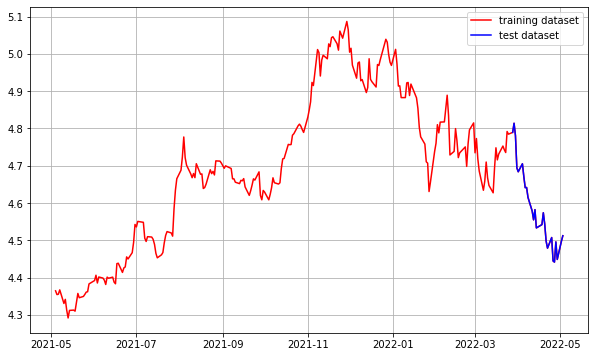

In [10]:
#데이터 스플릿
train_data, test_data = amd_log[:int(len(amd_log)*0.9)], amd_log[int(len(amd_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(amd_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

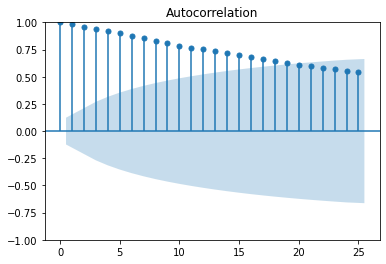

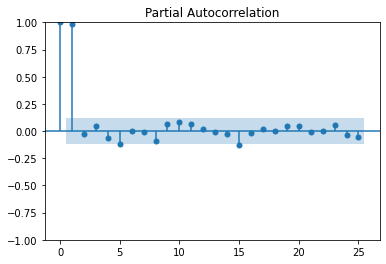

In [11]:
#amd log 변환으로는 비정상성을 처리하기 어려움. 따라서 차분을 통해 추세,계절성 제거가 필요
plot_acf(amd_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(amd_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -8.671366e+00
p-value                        4.536965e-14
#Lags Used                     2.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.035018e+00
p-value                        1.913006e-12
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.521912e+00
p-value                        1.094864e-13
#Lags Used                     1.600000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+

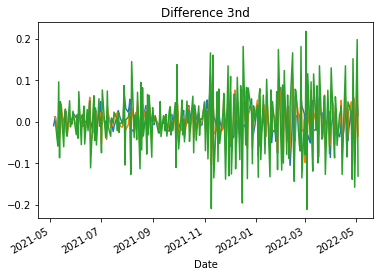

In [12]:
#차분 안정성 확인 d 구하기
## 1차 차분
diff_1 = amd_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Diff 1')

augmented_dickey_fuller_test(diff_1)

#2차,3차 차분
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

diff_3 = diff_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 3nd')

augmented_dickey_fuller_test(diff_3)

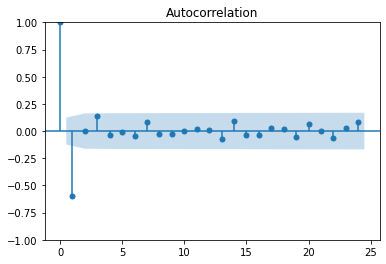

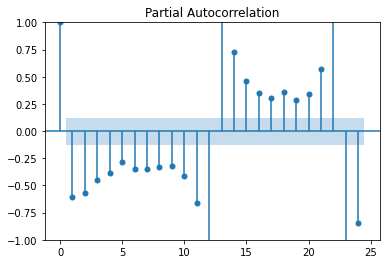

In [46]:
plot_acf(diff_3)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_3)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [14]:
model = ARIMA(train_data,order=(0,3,1))
fitted_m = model.fit()
print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(0, 3, 1)   Log Likelihood                 377.881
Date:                Wed, 04 May 2022   AIC                           -751.762
Time:                        15:10:47   BIC                           -744.938
Sample:                             0   HQIC                          -749.007
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9992      1.061     -0.942      0.346      -3.078       1.080
sigma2         0.0020      0.002      0.923      0.356      -0.002       0.006
Ljung-Box (L1) (Q):                  45.77   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


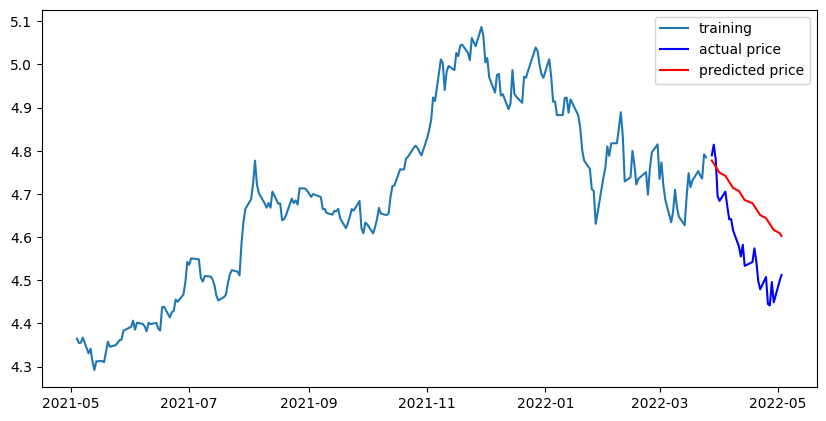

In [15]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [16]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  137.63831101316381
MAE:  10.822884755399636
RMSE:  11.73193551862453
MAPE: 11.51%


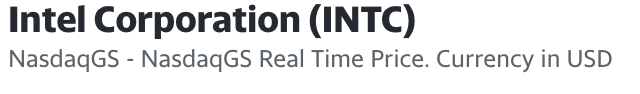

In [17]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/INTC.csv'
INTC = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
INTC = INTC['Close'] # 주식 종가
INTC

Date
2021-05-04    56.900002
2021-05-05    56.849998
2021-05-06    57.189999
2021-05-07    57.669998
2021-05-10    55.970001
                ...    
2022-04-27    45.220001
2022-04-28    46.840000
2022-04-29    43.590000
2022-05-02    44.959999
2022-05-03    45.060001
Name: Close, Length: 253, dtype: float64

In [18]:
#보간 : 연속성이 있는 데이터의 앞뒤값을 이용한 결측치 채우기
INTC = INTC.interpolate(method='time')
INTC[INTC.isna()]

Series([], Name: Close, dtype: float64)

In [19]:
#로그로 변환
INTC_log = np.log(INTC)
INTC_log

Date
2021-05-04    4.041295
2021-05-05    4.040416
2021-05-06    4.046379
2021-05-07    4.054737
2021-05-10    4.024816
                ...   
2022-04-27    3.811539
2022-04-28    3.846738
2022-04-29    3.774828
2022-05-02    3.805773
2022-05-03    3.807995
Name: Close, Length: 253, dtype: float64

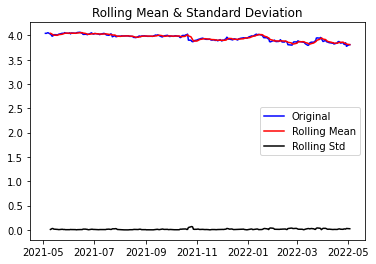

Results of Dickey-Fuller Test:
Test Statistic                  -1.915069
p-value                          0.325006
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


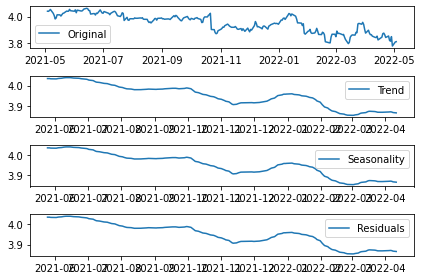

In [20]:
# 정성적 그래프 분석
plot_rolling_statistics(INTC_log, window=5)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(INTC_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(INTC_log, model='multiplicative', period = 30) 

trend = decomposition.trend # MA
seasonal = decomposition.seasonal #계절성 제거
residual = decomposition.resid

plt.subplot(411)
plt.plot(INTC_log,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(trend,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(trend,label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [21]:
#안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.533404e+00
p-value                        9.742313e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


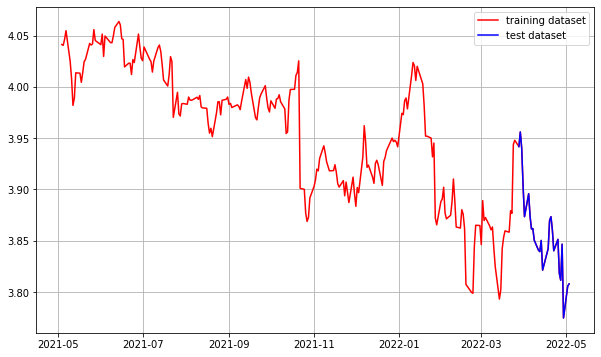

In [22]:
train_data, test_data = INTC_log[:int(len(INTC_log)*0.9)], INTC_log[int(len(INTC_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(INTC_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

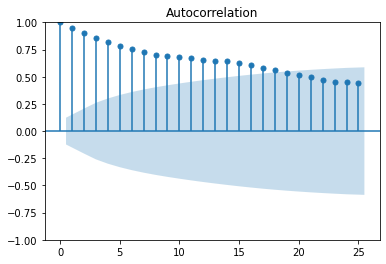

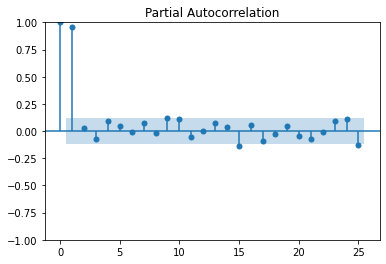

In [23]:
plot_acf(INTC_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(INTC_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.685964e+01
p-value                        1.102271e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.337750e+00
p-value                        3.237723e-13
#Lags Used                     1.400000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


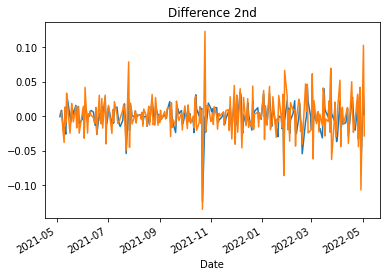

In [24]:
#차분 안정성 확인 d 구하기
## 1차 차분
diff_1 = INTC_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Diff 1')

augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

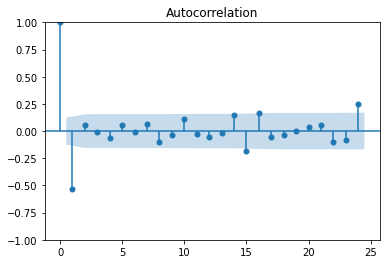

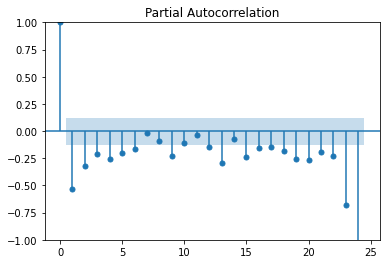

In [25]:
plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [26]:
model = ARIMA(train_data,order=(0,2,1))
fitted_m = model.fit()
print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 580.327
Date:                Wed, 04 May 2022   AIC                          -1156.654
Time:                        15:10:50   BIC                          -1149.822
Sample:                             0   HQIC                         -1153.897
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000     16.524     -0.061      0.952     -33.387      31.387
sigma2         0.0003      0.005      0.061      0.952      -0.010       0.011
Ljung-Box (L1) (Q):                   0.03   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


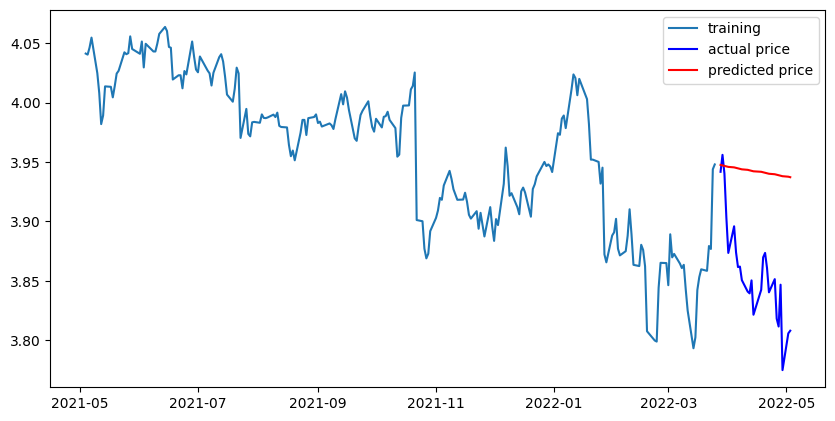

In [27]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [28]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  20.56338505685032
MAE:  4.1534806515070954
RMSE:  4.534686875281503
MAPE: 8.93%


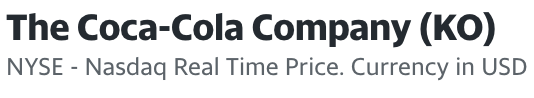

In [29]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/KO.csv'
KO = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
KO = KO['Close'] # 주식 종가
KO

Date
2021-05-04    54.139999
2021-05-05    54.000000
2021-05-06    54.540001
2021-05-07    54.509998
2021-05-10    54.910000
                ...    
2022-04-27    65.559998
2022-04-28    66.190002
2022-04-29    64.610001
2022-05-02    63.439999
2022-05-03    63.080002
Name: Close, Length: 253, dtype: float64

In [30]:
#보간 : 연속성이 있는 데이터의 앞뒤값을 이용한 결측치 채우기
KO = KO.interpolate(method='time')
KO[KO.isna()]

Series([], Name: Close, dtype: float64)

In [31]:
#로그로 변환
KO_log = np.log(KO)
KO_log

Date
2021-05-04    3.991573
2021-05-05    3.988984
2021-05-06    3.998934
2021-05-07    3.998384
2021-05-10    4.005695
                ...   
2022-04-27    4.182966
2022-04-28    4.192529
2022-04-29    4.168369
2022-05-02    4.150095
2022-05-03    4.144404
Name: Close, Length: 253, dtype: float64

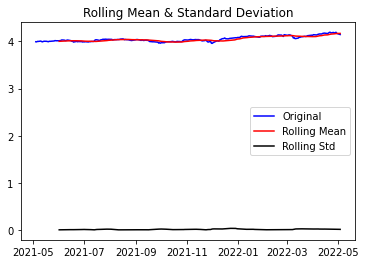

Results of Dickey-Fuller Test:
Test Statistic                  -1.062119
p-value                          0.729939
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


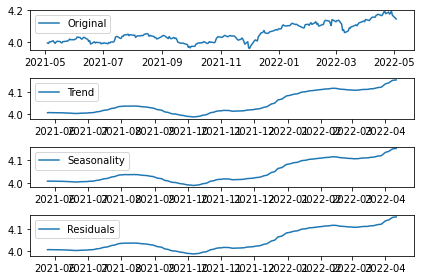

In [32]:
# 정성적 그래프 분석
plot_rolling_statistics(KO_log, window=20)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(KO_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(KO_log, model='multiplicative', period = 30) 

trend = decomposition.trend # MA
seasonal = decomposition.seasonal #계절성 제거
residual = decomposition.resid

plt.subplot(411)
plt.plot(KO_log,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(trend,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(trend,label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [33]:
#안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.090506
p-value                          0.000015
#Lags Used                       3.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


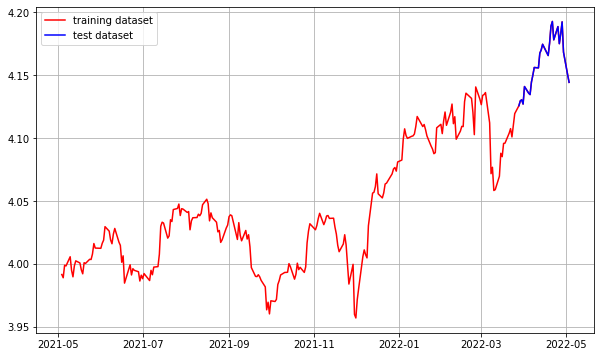

In [34]:
train_data, test_data = KO_log[:int(len(KO_log)*0.9)], KO_log[int(len(KO_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(KO_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

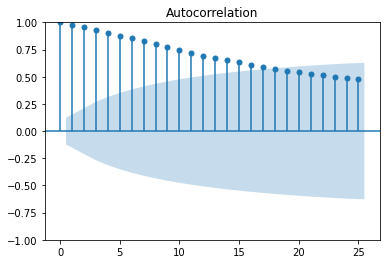

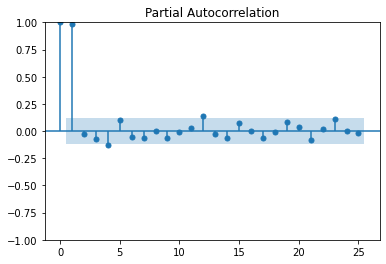

In [35]:
plot_acf(KO_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(KO_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.685964e+01
p-value                        1.102271e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.337750e+00
p-value                        3.237723e-13
#Lags Used                     1.400000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


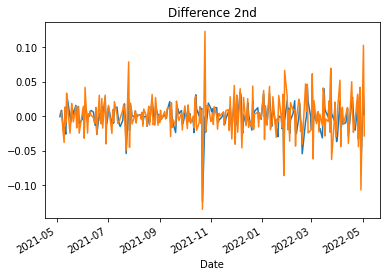

In [36]:
#차분 안정성 확인 d 구하기
## 1차 차분
diff_1 = INTC_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Diff 1')

augmented_dickey_fuller_test(diff_1)

#혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

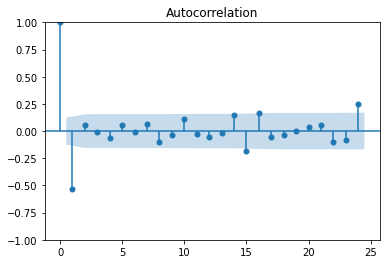

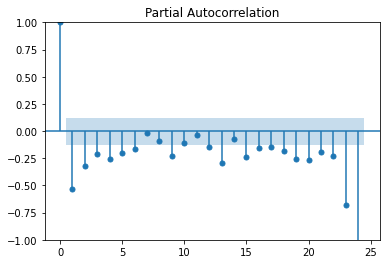

In [37]:
plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [38]:
model = ARIMA(train_data,order=(0,2,3))
fitted_m = model.fit()
print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(0, 2, 3)   Log Likelihood                 714.616
Date:                Wed, 04 May 2022   AIC                          -1421.231
Time:                        15:10:54   BIC                          -1407.567
Sample:                             0   HQIC                         -1415.716
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8898      0.050    -17.696      0.000      -0.988      -0.791
ma.L2          0.0229      0.063      0.361      0.718      -0.101       0.147
ma.L3         -0.0181      0.055     -0.329      0.7

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


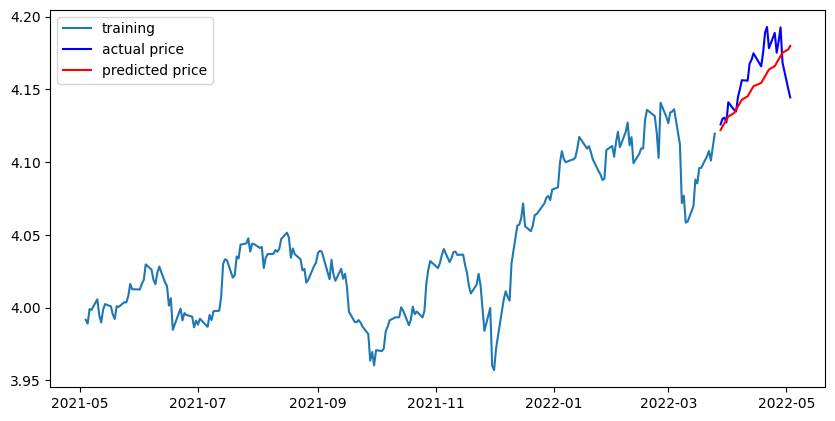

In [39]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [40]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1.2288715338940015
MAE:  0.9132035855474414
RMSE:  1.108544782087761
MAPE: 1.41%


## Auto_ARIMA 맛보기

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-1284.032, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-1355.059, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-1381.034, Time=0.20 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-1384.299, Time=0.18 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-1427.354, Time=0.62 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-1427.966, Time=0.80 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.99 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=-1425.710, Time=0.50 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=inf, Time=1.44 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-1423.110, Time=0.89 sec

Best model:  ARIMA(3,2,2)(0,0,0)[0]          
Total fit time: 6.729 seconds
                               SARIMAX Results                                
Dep. Variable:       

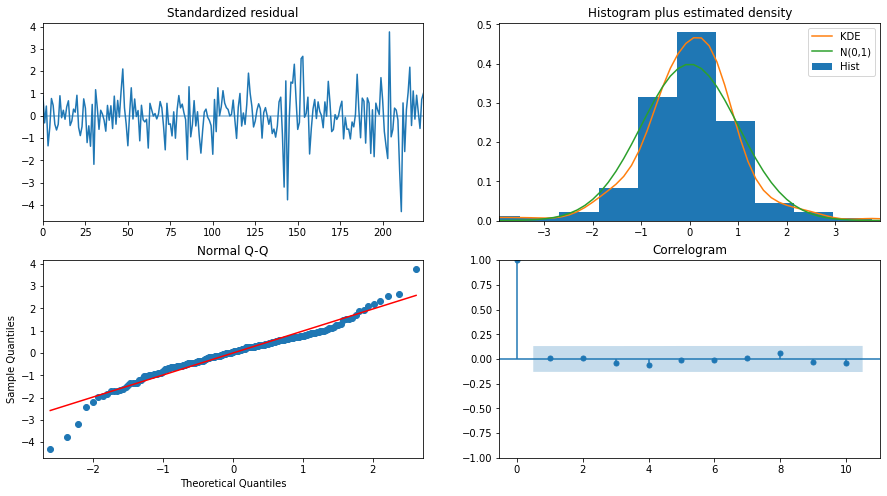

In [41]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [42]:
model = ARIMA(train_data, order=(3,2,2))  
fitted = model.fit()  
print(fitted.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(3, 2, 2)   Log Likelihood                 719.983
Date:                Wed, 04 May 2022   AIC                          -1427.966
Time:                        15:11:02   BIC                          -1407.470
Sample:                             0   HQIC                         -1419.694
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8226      0.251     -3.278      0.001      -1.314      -0.331
ar.L2         -0.0027      0.085     -0.032      0.974      -0.169       0.163
ar.L3          0.0779      0.065      1.195      0.2

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


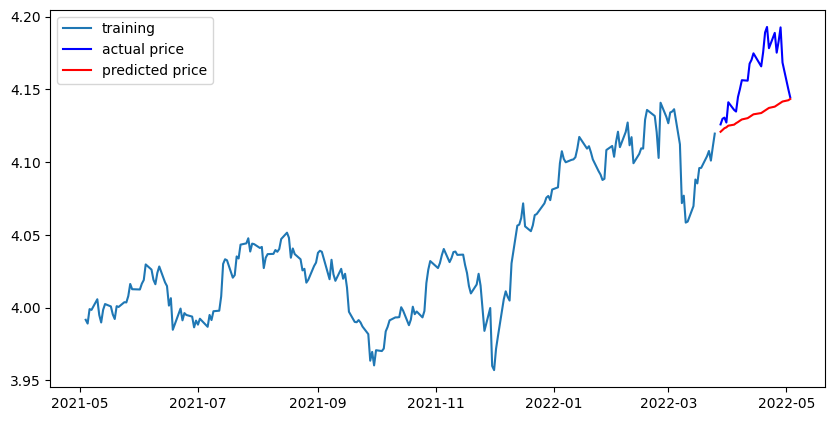

In [43]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [44]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4.23425934400308
MAE:  1.7327901383117845
RMSE:  2.0577316015464895
MAPE: 2.67%


## 회고록
#### 시계열 자료의 구성
    - 시계열 자료 = 추세성분+순환성분+계절성분+불규칙성분
        - 추세성분 : 관측값이 지속적으로 증가하거나 감소하는 추세를 갖는 경우의 변동
        - 순환성분 : 주기적 변화를 가지나 계절의 영향이 아니며, 주기가 긴 경우
        - 계절성분 : 계절의 변화에 따른 주기적 변동
        - 불규칙성분 : 랜덤 원인에 의한 변동
        
#### ACF , PACF에 대해
    - 자기상관함수(Autocorrelation Function, ACF)
        - $y_{t} 와 y_{t+k}사이의 correlation으로 얼마나 관계가 있는지 측정하는 것 MA(q)값을 결정$
    - 편자기상관함수(Partial Autocorrelation Function, PACF)
        - $자기상관함수 - (t와 (t+k) 사이의 y값)으로 y_{t}와 y_{t+k}의 관계만 측정 AR(p)값을 결정$
        
#### 차분
    - 비정상성 시계열을 정상성 시계열로 변환하는 역할을 담당.
    - 결과적을 추세, 계절성이 감소되거나 제거됨.
    - 일부 블로그에서 3차이상의 차분은 의미가 없다고 기술하고 있지만 어떤 이유에서 인지는 찾지 못함.  
    (출처:https://velog.io/@sjina0722/%EC%8B%9C%EA%B3%84%EC%97%B4%EB%B6%84%EC%84%9D-ARIMA-%EB%AA%A8%EB%8D%B8)
    
    
#### 분석 기업
    - AMD : ARIMA(0,3,1) MAPE : 11.51%
    2차 차분의 ACF도 어느정도 안정적이라 생각해 IMA(d,q)에 여러 값들을 넣으며 실험했지만 유의미한 결과가 나오지 않았다. 위에 기술한 것처럼 3차 차분 쓰지않고는 불가능할 것 같아 3차 차분을 진행하였는데 PACF 그래프가 날뛰는 모습을 보여주었다. ACF그래프가 lag 1에서 박스권으로 수렴하는 것을 근거로 (0,3,1)의 인자를 선택하였고 가장 안정적인 MAPE가 도출되었지만, 정상적으로 데이터를 가공해서 시계열 분석을 하였는가에 대한 의문은 아직 풀리지 않은 문제이다. (최근 급속도로 성장한 계열의 주식이라서 시계열만으로 예측하는데 한계가 있는 것인지)
    
    
    - INTC(Intel) : ARIMA (0,2,1) MAPE : 8.93%
    AMD와 정반대의 길을 걷고있는 주식이라 선정하였다. 꾸준히 우하향하는 모습도 보여주었고 폭락도 경험한 주식의 예측력이 얼마나 나올지 궁금했는데 의외로 더 안정적인 예측치가 나와서 의아했다.  2차 차분의 ACF상에서 마지막 수치가 박스권을 이탈하는 모습을 보여주어 3차 차분까지 진행해야하는지 고민하였지만 2차 차분만으로 10%를 하회하는 수치를 보여주어 (0,2,1)로 결정하였다.  
            다만 predicted price가 AMD에 비해 실제 데이터와 거리가 더 먼 형태를 띄고있는데 MAPE는 낮게 나오는 모습을 볼때 시계열 평가지표에 대한 이해가 부족함을 인지하였다. 
            
            
    - KO(Coca-Cola) : ARIMA (0,2,3) MAPE : 1.41% Auto-ARIMA (3,2,2) MAPE : 2.67%
    위 두 기업과 다른 소비재 기업으로 주가에 영향을 주는 요인이 완전히 다르기에 선정하였다. 또한 p,d,q를 GridSearch와 비슷한 방법으로 찾아주는 모델이 있다고 해서 가장 안정적으로 보이는 해당 기업을 시험삼아 넣어보았다. ACF,PACF 상으로는 INTC와 큰 차이가 없어 (0,2,1)부터 MA(q)를 증가시키며 실험하였는데, (0,2,3)에서 가장 좋은 수치를 보여주었다. 여러 블로그와 문서를 찾아보며 이론상으론 ACF를 기반으로 수치를 적용해야하지만 실제 이렇게 예측력이 유의미하게 높아지는 상황에서는 어떻게 선정해야할지 고민할 수 밖에 없었다. 또한 노드에서 밝힌 일반적으로 선택하는 수치 기준인 p+q<2 P*q=0 를 벗어나서 오토모델은 (3,2,2)를 선정하였고 나쁘지않은 수치를 기록하는 것을 볼때 어떠한 기준으로 선정해야할지 전반적으로 어려움을 겪었다.
        
        
#### 총평
   Warning이 어떤 이유때문에 출력되는지 알기가 어려웠다.  
   통계지식 없이는 데이터 처리, 모델 인자 선정등 많은 부분에서 어려움을 겪을 수 밖에 없음을 절실히 알게 되었다.  
   동시에 시계열 분석의 흐름을 이해하기에는 여러 문건들이 난이도가 높은 측면이 있었다.  
   다만 충분히 준비해서 다른 모델과 결합한 데이터 분석을 준비하면 큰 메리트가 될 것이라 생각하였다.